In [1]:
import pandas as pd
from kafka import KafkaConsumer
import pickle
from sklearn.metrics import f1_score
from sklearn.feature_extraction import FeatureHasher
import json
from sklearn.model_selection import train_test_split


In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [3]:
for m in consumer:
        m.value
        break

In [4]:
# Load the Static Model
with open('THE_STATIC_MODEL.pkl', 'rb') as file:
    loaded_pipe = pickle.load(file)
# Load the Static Model
with open('THE_STATIC_MODEL.pkl', 'rb') as file:
    loaded_pipe_dynamic = pickle.load(file)


In [5]:
# Extract components from the loaded pipeline
scaler = loaded_pipe.named_steps['scaler']
static_model =   loaded_pipe.named_steps['classifier']
selected_features = loaded_pipe.named_steps['selected_features']  # Assuming this is a list
dynamic_model = loaded_pipe_dynamic.named_steps['classifier']

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
import pickle


In [7]:
data= pd.read_csv("Static_dataset.csv")

In [8]:
sample_size = 40000
data, _ = train_test_split(data, test_size=(len(data) - sample_size) / len(data), stratify=data["Target Attack"], random_state=42)

In [9]:
data.isna().sum().any()

False

In [10]:
data.dropna(inplace=True)

In [11]:
data.isna().sum().any()

False

In [12]:
duplicate_rows = data.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# Drop duplicate rows if any
if duplicate_rows.sum() > 0:
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

# Continue with the rest of your data cleansing process
data.isnull().sum()


Number of duplicate rows: 2845
Duplicate rows dropped.


timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

In [13]:
from sklearn.feature_extraction import FeatureHasher

# Hash the sld feature column
n_sld = 4
sld_hash = FeatureHasher(n_features=n_sld, input_type="string")
sld_hashed = sld_hash.transform(data['sld'].apply(lambda x: [str(x)]))

sld_col = [f'sld_hashed_{i}' for i in range(n_sld)]
sld_hashed_df = pd.DataFrame(sld_hashed.toarray(), columns = sld_col , index = data.index)


In [14]:
# Hash the longest_word feature column
n_lw = 4
lw_hash = FeatureHasher(n_features=n_lw, input_type="string")
lw_hashed = lw_hash.transform(data['longest_word'].apply(lambda x: [str(x)]))

lw_col = [f'lw_hashed_{i}' for i in range(n_lw)]
lw_hashed_df = pd.DataFrame(lw_hashed.toarray(), columns = lw_col, index = data.index)



In [15]:
# Collect all the features
data = pd.concat([data, sld_hashed_df, lw_hashed_df], axis=1)

In [16]:
# Drop the 'timestamp', 'longest_word', and 'sld' columns
data = data.drop(['timestamp', 'longest_word', 'sld'], axis=1)

In [17]:
data.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,...,subdomain,Target Attack,sld_hashed_0,sld_hashed_1,sld_hashed_2,sld_hashed_3,lw_hashed_0,lw_hashed_1,lw_hashed_2,lw_hashed_3
250440,24,7,0,10,8,2.054029,6,6,7,3.166667,...,1,1,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0
58775,9,0,0,8,0,2.120590,1,2,6,4.000000,...,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
197835,24,7,0,10,8,2.054029,6,6,7,3.166667,...,1,1,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0
148039,25,8,0,10,9,2.786216,6,6,7,3.333333,...,1,0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
178413,25,8,0,10,9,2.556642,6,6,7,3.333333,...,1,1,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0


In [18]:
X_old = data.drop(columns=['Target Attack'])
y_old = data['Target Attack']

In [19]:
# Apply MinMaxScaler after splitting
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X_old)


In [20]:
X_scaled_df = pd.DataFrame(X_scale, columns=X_old.columns)


In [21]:
X_scaled_df

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,sld_hashed_0,sld_hashed_1,sld_hashed_2,sld_hashed_3,lw_hashed_0,lw_hashed_1,lw_hashed_2,lw_hashed_3
0,0.666667,0.318182,0.0,0.3125,0.666667,0.467577,0.857143,1.0,0.166667,0.038889,0.266667,1.0,0.5,0.5,1.0,0.5,0.0,0.5,0.5,0.5
1,0.212121,0.000000,0.0,0.2500,0.000000,0.484539,0.142857,0.2,0.133333,0.066667,0.133333,0.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5
2,0.666667,0.318182,0.0,0.3125,0.666667,0.467577,0.857143,1.0,0.166667,0.038889,0.266667,1.0,0.5,0.5,1.0,0.5,0.0,0.5,0.5,0.5
3,0.696970,0.363636,0.0,0.3125,0.750000,0.654163,0.857143,1.0,0.166667,0.044444,0.300000,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0
4,0.696970,0.363636,0.0,0.3125,0.750000,0.595659,0.857143,1.0,0.166667,0.044444,0.300000,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37150,0.666667,0.318182,0.0,0.3125,0.666667,0.467577,0.857143,1.0,0.166667,0.038889,0.266667,1.0,0.5,0.5,1.0,0.5,0.0,0.5,0.5,0.5
37151,0.757576,0.454545,0.0,0.3125,0.916667,0.649315,0.857143,1.0,0.166667,0.055556,0.366667,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0
37152,0.242424,0.000000,0.0,0.2500,0.000000,0.613079,0.285714,0.2,0.166667,0.083333,0.166667,0.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5
37153,0.727273,0.409091,0.0,0.3125,0.833333,0.642981,0.857143,1.0,0.166667,0.050000,0.333333,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0


In [22]:
X_selected=X_scaled_df[selected_features]

In [23]:
X_selected

,len,subdomain_length,subdomain,numeric,special,FQDN_count,lower,labels
0,0.266667,0.318182,1.0,0.666667,0.857143,0.666667,0.3125,1.0
1,0.133333,0.000000,0.0,0.000000,0.142857,0.212121,0.2500,0.2
2,0.266667,0.318182,1.0,0.666667,0.857143,0.666667,0.3125,1.0
3,0.300000,0.363636,1.0,0.750000,0.857143,0.696970,0.3125,1.0
4,0.300000,0.363636,1.0,0.750000,0.857143,0.696970,0.3125,1.0
...,...,...,...,...,...,...,...,...
37150,0.266667,0.318182,1.0,0.666667,0.857143,0.666667,0.3125,1.0
37151,0.366667,0.454545,1.0,0.916667,0.857143,0.757576,0.3125,1.0
37152,0.166667,0.000000,0.0,0.000000,0.285714,0.242424,0.2500,0.2
37153,0.333333,0.409091,1.0,0.833333,0.857143,0.727273,0.3125,1.0


In [24]:
def get_1000_record(itr):
    list_of_1000_record=[]
    i=0
    for c in consumer:
        if i <1000:
            list_of_1000_record.append(c.value)
            i=i+1
        else:
            break
    print(f"Window {itr}")
    return list_of_1000_record

In [25]:
def preprocess_data(df):
    df.dropna(inplace=True)
    # Feature Hashing for 'sld' and 'longest_word'
    n_sld = 4
    sld_hash = FeatureHasher(n_features=n_sld, input_type="string")
    sld_hashed = sld_hash.transform(df['sld'].apply(lambda x: [str(x)]))

    sld_col = [f'sld_hashed_{i}' for i in range(n_sld)]
    sld_hashed_df = pd.DataFrame(sld_hashed.toarray(), columns = sld_col , index = df.index)
    
    # Hash the longest_word feature column
    n_lw = 4
    lw_hash = FeatureHasher(n_features=n_lw, input_type="string")
    lw_hashed = lw_hash.transform(df['longest_word'].apply(lambda x: [str(x)]))

    lw_col = [f'lw_hashed_{i}' for i in range(n_lw)]
    lw_hashed_df = pd.DataFrame(lw_hashed.toarray(), columns = lw_col, index = df.index)
    df = pd.concat([df, sld_hashed_df, lw_hashed_df], axis=1)
    


    df = df.drop(['timestamp', 'longest_word', 'sld'], axis=1)    

    return df

In [26]:
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max",
            "labels_average","longest_word","sld","len","subdomain","Target Attack"]
def convert_to_dataframe( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [27]:
def retrain_model(model,X,y):
    return model.fit(X,y)


In [28]:
selected_features 


['len',
 'subdomain_length',
 'subdomain',
 'numeric',
 'special',
 'FQDN_count',
 'lower',
 'labels']

In [29]:
f1_for_Dynmaic_model=[]
f1_for_static_model=[]
f1_for_Dynmaic_stream_model=[]
f1_for_static_stream_model=[]
for i in range(266):
    raw_data = get_1000_record(i)
    final_data =convert_to_dataframe(raw_data)
    preprocessed_data = preprocess_data(final_data)
    
    # Separate features and target
    X = preprocessed_data.drop('Target Attack', axis=1)
    y = preprocessed_data['Target Attack'].astype(int)

    # Scaling the features
    X_scaled = scaler.transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    # Select features
    X_feature_select = X_scaled_df[selected_features]
    # Evaluate Static Model
    y_pred_static = static_model.predict(X_feature_select)
    static_f1_score = f1_score(y, y_pred_static)
    print("F1 Score for Static",static_f1_score)
    # Evaluate Dynamic Model
    y_pred_dynamic = dynamic_model.predict(X_feature_select)
    dynamic_f1_score = f1_score(y, y_pred_dynamic)
    print("F1 Score for Dynamic before Train",dynamic_f1_score)
    # Decision to Retrain
    # Concatenate y and y_old side by side
    

    
    
    if dynamic_f1_score < 0.86:
        y_combined = pd.concat([y, y_old])
        X_combined = pd.concat([X_feature_select, X_selected])
        print("start train")
        dynamic_model = retrain_model(dynamic_model,X_combined,y_combined)
        y_pred_dynamic = dynamic_model.predict(X_feature_select)
        dynamic_f1_score = f1_score(y, y_pred_dynamic)
        print("F1 Score for Dynamic after Train with append",dynamic_f1_score)
    f1_for_Dynmaic_model.append(dynamic_f1_score)
    f1_for_static_model.append(static_f1_score)
    print(f"{'*'*40}")

Window 0
F1 Score for Static 0.8465266558966076
F1 Score for Dynamic before Train 0.8465266558966076
start train


F1 Score for Dynamic after Train with append 0.8486312399355878
****************************************
Window 1
F1 Score for Static 0.8521739130434782
F1 Score for Dynamic before Train 0.8548895899053627
start train
F1 Score for Dynamic after Train with append 0.8548895899053627
****************************************
Window 2
F1 Score for Static 0.8389105058365759
F1 Score for Dynamic before Train 0.8418604651162791
start train
F1 Score for Dynamic after Train with append 0.8418604651162791
****************************************
Window 3
F1 Score for Static 0.8560431100846806
F1 Score for Dynamic before Train 0.8588957055214724
start train
F1 Score for Dynamic after Train with append 0.8588957055214724
****************************************
Window 4
F1 Score for Static 0.8381877022653721
F1 Score for Dynamic before Train 0.8461538461538461
start train
F1 Score for Dynamic after Train with append 0.8461538461538461
****************************************
Window 5
F1 Score for S

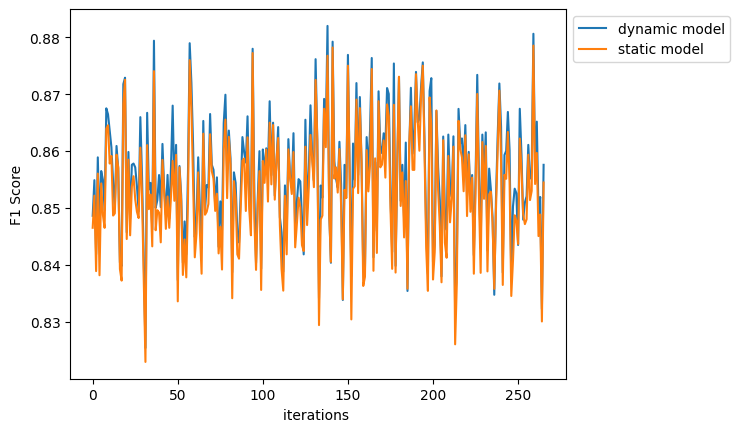

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(266), f1_for_Dynmaic_model, label=f'dynamic model')
plt.plot(range(266),f1_for_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")